# Tidal regression

**What does this notebook do?** 

This notebook uses the ([OSU Tidal Prediction Software or OTPS](http://volkov.oce.orst.edu/tides/otps.html)) to tidally tag a time series of Landsat imagery, and then compute pixel-wise regression based on NDWI values.

**Requirements:** 

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

`module load otps`

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** August 2018

**Authors:** Robbi Bishop-Taylor, Bex Dunn

## Import modules

In [1]:
%matplotlib inline

#get standard libraries
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy import stats, signal
import sys
import xarray as xr

#get DEA modules
import datacube
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from otps import TimePoint
from otps import predict_tide

# Import external functions from dea-notebooks using relative link to Scripts
sys.path.append('../10_Scripts')
import DEAPlotting
import DEADataHandling

%load_ext autoreload
%autoreload 2

# Create datacube instance
dc = datacube.Datacube(app='Tidal regression')

### define notebook-specific functions

In [ ]:
# #This function applies a linear regression to a grid over a set time interval
# def linear_regression_grid(input_array, mask_no_trend = False):
#     '''
#     This function applies a linear regression to a grid over a set time interval by looping through lat and lon 
#     and calculating the linear regression through time for each pixel.
#     '''
#     #print(input_array.tide_heights)
#     ylen = len(input_array.y)
#     xlen = len(input_array.x)
#     from itertools import product
#     coordinates = product(range(ylen), range(xlen))

#     slopes = np.zeros((ylen, xlen))
#     p_values = np.zeros((ylen, xlen))
#     #print('Slope shape is ', slopes.shape)

#     for y, x in coordinates:
#         val = input_array.isel(x = x, y = y)
#         #print (val.tide_heights, val.mndwi)
#         data_mask=np.isfinite(val.mndwi)
#         if len(val.mndwi[data_mask]):
#             #only calculate regression if all values are not NaN
#             slopes[y, x], intercept, r_sq, p_values[y, x], std_err = stats.linregress(val.tide_heights[data_mask],val.mndwi[data_mask])

# #     #Get coordinates from the original xarray
#     lat  = input_array.coords['y']
#     long = input_array.coords['x']
# #     #Mask out values with insignificant trends (ie. p-value > 0.05) if user wants
#     if mask_no_trend == True:
#         slopes[p_values>0.05]=np.nan        
#     # Write arrays into a x-array
#     slope_xr = xr.DataArray(slopes, coords = [lat, long], dims = ['y', 'x'])
#     p_val_xr = xr.DataArray(p_values, coords = [lat, long], dims = ['y', 'x']) 
#     return slope_xr, p_val_xr

def lag_linregress_3D_upright(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions 
    (time,lat,lon).Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n = y.notnull().sum(dim='time')
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr


## Import remotely-sensed time series data
Imports a time series of Landsat observations as a DEA `xarray` dataset.

In [ ]:
# Set up analysis data query using 
lat, lon, buffer_x, buffer_y = -12.463, 130.885, 3500, 3500  # Darwin
lat, lon, buffer_x, buffer_y = -12.265, 132.273, 3500, 8000  # Alligator
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer_x, x + buffer_x),
         'y': (y - buffer_y, y + buffer_y),         
         'crs': 'EPSG:3577',
         'time': ('1986-01-01', '2018-06-30')}

# Mask used to identify bad pixels
mask_dict = {'cloud_acca': 'no_cloud', 
             'cloud_fmask': 'no_cloud', 
             'cloud_shadow_acca':'no_cloud_shadow',
             'cloud_shadow_fmask':'no_cloud_shadow',
             'blue_saturated':False,
             'green_saturated':False,
             'red_saturated':False,
             'nir_saturated':False,
             'swir1_saturated':False,
             'swir2_saturated':False,
             'contiguous': True}

# Import data
data = DEADataHandling.load_clearlandsat(dc=dc, query=query, sensors=['ls5', 'ls7', 'ls8'],
                                         bands_of_interest=['swir1', 'nir', 'green'],
                                         mask_dict=mask_dict, masked_prop=0, apply_mask=True)

# Plot data
data[['swir1', 'nir', 'green']].isel(time=6).to_array().plot.imshow(robust=True)


Loading ls5 PQ
    Loading 372 filtered ls5 timesteps
Ignoring SLC-off observations for ls7
Loading ls7 PQ
    Loading 79 filtered ls7 timesteps
Loading ls8 PQ
    Loading 117 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data


## Tidal modelling using OTPS
and extracts a list of timestamps based on the time and date of acquisition for each Landsat observation. These timestamps can then be used as one of the inputs to the [OSU Tidal Prediction Software (OTPS) tidal model](http://volkov.oce.orst.edu/tides/otps.html) to compute tidal heights at the time of acquisition of each Landsat observation.

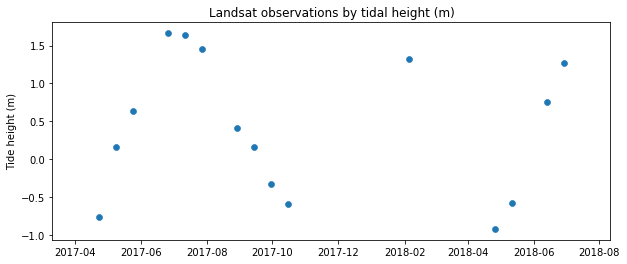

In [60]:
# Extract list of datetimes based on Landsat time of acquisition for each image
observed_datetimes = data.time.data.astype('M8[s]').astype('O').tolist()

#Set a tide post: this is the location the OTPS model uses to compute tides for the supplied datetimes
tidepost_lat, tidepost_lon = -12.48315, 130.85540  # Darwin Harbour
tidepost_lat, tidepost_lon = -12.1982891466, 132.284149706  # Alligator

# The OTPS model requires inputs as 'TimePoint' objects, which are combinations of lon-lat coordinates 
# and a datetime object. You can create a list of these with a list comprehension:
observed_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) for dt in observed_datetimes]

# Feed the entire list of timepoints to the OTPS `predict_tide` function:
observed_predictedtides = predict_tide(observed_timepoints)

# For each of the predicted tide objects, extract a list of tidal heights in `m` units relative to mean 
# sea level (the `tide_m` method should not be confused with the `depth_m` method, which gives you the 
# ocean depth at the tide post location that is used by the OTPS model to predict tides)
observed_tideheights = [predictedtide.tide_m for predictedtide in observed_predictedtides]

# Create a dataframe of tidal heights for each Landsat observation
observed_df = pd.DataFrame({'tide_height': observed_tideheights}, 
                           index=pd.DatetimeIndex(observed_datetimes))

# Plot tidal heights against Landsat observation date
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(observed_df.index, observed_df.tide_height, linewidth=0.6, zorder=1, label='Modelled')
ax.set_title('Landsat observations by tidal height (m)')
ax.set_ylabel('Tide height (m)');


### Tagging, filtering and compositing Landsat observations by tidal height/stage
Adds tidal height data back into our original `xarray` dataset so that each Landsat observation is correctly tagged with its corresponding tidal height. Tagged images can then be filtered or composited to study characteristics of the coastline at various tidal stages.

In [5]:
## make the shape of the tide height data equal to mndwi for ease of regression calc

In [8]:
tide_heights = xr.DataArray(observed_tideheights, 
                            [('time', data.time)])

data['tide_heights'] = tide_heights

In [7]:
#use broadcasting to explicitly get the size of height data to match mndwi
# _, broad_tide_heights = xr.broadcast(data, tide_heights)
# data['tide_heights'] = broad_tide_heights

## Compute MNDWI for all timesteps

In [3]:
data['mndwi'] = (data.green - data.swir1) / (data.green + data.swir1)

In [9]:
#data['mndwi'].plot(col='time', col_wrap=6, robust=True)

### Linear regression of mndwi vs tide height


In [10]:
#drop our variables we don't want
# data=data.drop(['data_perc','swir1','nir','green'])

In [11]:
# slope, pval = linear_regression_grid(data)

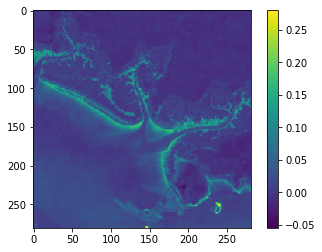

In [12]:
# plt.imshow(slope.data)
# plt.colorbar()
# plt.show()

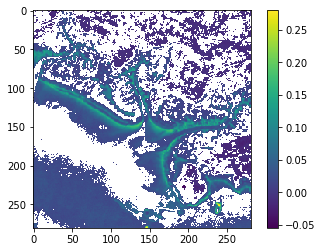

In [13]:
# slopes_masked = slope.where(pval<0.05)
# plt.imshow(slopes_masked.data)
# plt.colorbar()
# plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f09fe9bd860>]],
      dtype=object)

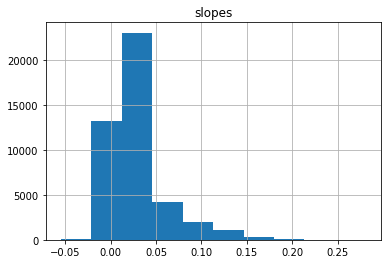

In [14]:
# slopes_masked.to_dataframe(name='slopes').hist()

In [15]:
from  scipy import stats, signal #Required for detrending data and computing regression

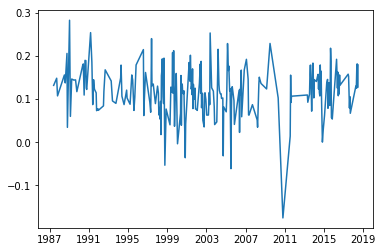

In [9]:
plt.plot(data.time, data.mndwi.mean(dim=('x','y')), label = 'original')

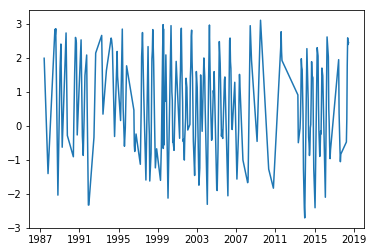

In [11]:
plt.plot(data.time, data.tide_heights, label = 'original')

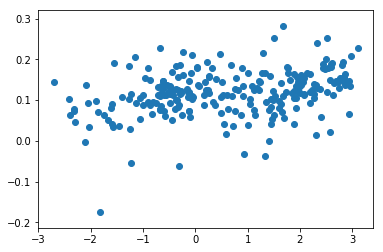

In [16]:
plt.scatter(data.tide_heights ,data.mndwi.mean(dim=('x','y')))

In [20]:
# def lag_linregress_3D(x, y, lagx=0, lagy=0):
#     """
#     Input: Two xr.Datarrays of any dimensions with the first dim being time. 
#     Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
#     Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
#     for y with respect to x.
#     Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
#     between the two datasets along their aligned time dimension.  
#     Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
#     """ 
#     #1. Ensure that the data are properly alinged to each other. 
#     x,y = xr.align(x,y)
    
#     #2. Add lag information if any, and shift the data accordingly
#     if lagx!=0:
#         #If x lags y by 1, x must be shifted 1 step backwards. 
#         #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
#         x   = x.shift(time = -lagx).dropna(dim='time')
#         #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
#         x,y = xr.align(x,y)

#     if lagy!=0:
#         y   = y.shift(time = -lagy).dropna(dim='time')
#         x,y = xr.align(x,y)
 
#     #3. Compute data length, mean and standard deviation along time axis for further use: 
#     n     = x.shape[0]
#     xmean = x.mean(axis=0)
#     ymean = y.mean(axis=0)
#     xstd  = x.std(axis=0)
#     ystd  = y.std(axis=0)
    
#     #4. Compute covariance along time axis
#     cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
#     #5. Compute correlation along time axis
#     cor   = cov/(xstd*ystd)
    
#     #6. Compute regression slope and intercept:
#     slope     = cov/(xstd**2)
#     intercept = ymean - xmean*slope  
    
#     #7. Compute P-value and standard error
#     #Compute t-statistics
#     tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
#     stderr = slope/tstats
    
#     from scipy.stats import t
#     pval   = t.sf(tstats, n-2)*2
#     pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

#     return cov,cor,slope,intercept,pval,stderr

In [21]:
data

<xarray.Dataset>
Dimensions:       (time: 238, x: 281, y: 281)
Coordinates:
  * y             (y) float64 -1.312e+06 -1.312e+06 -1.312e+06 -1.312e+06 ...
  * x             (x) float64 -1.269e+05 -1.269e+05 -1.268e+05 -1.268e+05 ...
  * time          (time) datetime64[ns] 1987-05-30T00:47:23 ...
Data variables:
    tide_heights  (time, x, y) float64 1.986 1.986 1.986 1.986 1.986 1.986 ...
    mndwi         (time, y, x) float64 -0.2922 -0.343 -0.3974 -0.3869 ...
Attributes:
    crs:      EPSG:3577

In [23]:
# def lag_linregress_3D(x, y, lagx=0, lagy=0):
#     """
#     Input: Two xr.Datarrays of any dimensions with the first dim being time. 
#     Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
#     Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
#     for y with respect to x.
#     Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
#     between the two datasets along their aligned time dimension.  
#     Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
#     """ 
#     #1. Ensure that the data are properly alinged to each other. 
#     x,y = xr.align(x,y)
    
#     #2. Add lag information if any, and shift the data accordingly
#     if lagx!=0:
#         #If x lags y by 1, x must be shifted 1 step backwards. 
#         #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
#         x   = x.shift(time = -lagx).dropna(dim='time')
#         #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
#         x,y = xr.align(x,y)

#     if lagy!=0:
#         y   = y.shift(time = -lagy).dropna(dim='time')
#         x,y = xr.align(x,y)
 
#     #3. Compute data length, mean and standard deviation along time axis for further use: 
#     n     = x.shape[0]
#     xmean = x.mean(axis=0)
#     ymean = y.mean(axis=0)
#     xstd  = x.std(axis=0)
#     ystd  = y.std(axis=0)
    
#     #4. Compute covariance along time axis
#     cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
#     #5. Compute correlation along time axis
#     cor   = cov/(xstd*ystd)
    
#     #6. Compute regression slope and intercept:
#     slope     = cov/(xstd**2)
#     intercept = ymean - xmean*slope  
    
#     #7. Compute P-value and standard error
#     #Compute t-statistics
#     tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
#     stderr = slope/tstats
    
#     from scipy.stats import t
#     pval   = t.sf(tstats, n-2)*2
#     pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

#     return cov,cor,slope,intercept,pval,stderr

In [24]:
# cov2,cor2,slope2,intercept2,pval2,stderr2 = lag_linregress_3D(data['tide_heights'],
#                                                               data['mndwi'])

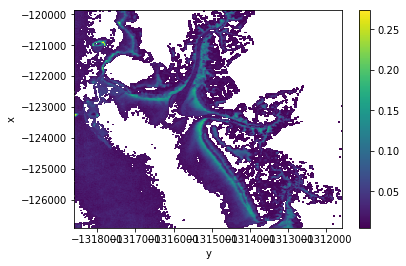

In [44]:
# slopes2_masked.plot()

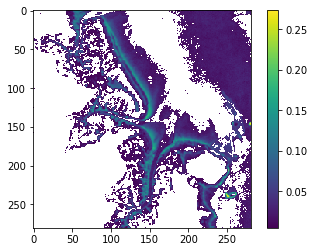

In [29]:
# slopes2_masked = slope2.where(pval2<0.05)
# plt.imshow(slopes2_masked.data)
# plt.colorbar()
# plt.show()

In [30]:
data

<xarray.Dataset>
Dimensions:       (time: 238, x: 281, y: 281)
Coordinates:
  * y             (y) float64 -1.312e+06 -1.312e+06 -1.312e+06 -1.312e+06 ...
  * x             (x) float64 -1.269e+05 -1.269e+05 -1.268e+05 -1.268e+05 ...
  * time          (time) datetime64[ns] 1987-05-30T00:47:23 ...
Data variables:
    tide_heights  (time, x, y) float64 1.986 1.986 1.986 1.986 1.986 1.986 ...
    mndwi         (time, y, x) float64 -0.2922 -0.343 -0.3974 -0.3869 ...
Attributes:
    crs:      EPSG:3577

In [31]:
###change assumption that time domain is axis of importance

In [27]:
cov,cor,slope,intercept,pval,stderr = lag_linregress_3D_upright(data['tide_heights'],
                                                                data['mndwi'])

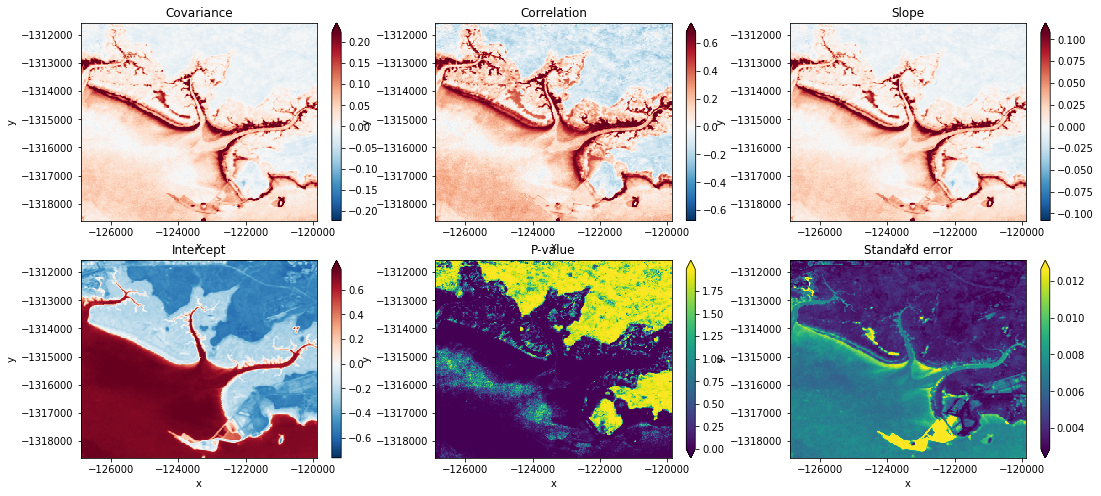

In [33]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 8))
cov.plot(robust=True, ax=ax1)
ax1.set_title('Covariance')
cor.plot(robust=True, ax=ax2)
ax2.set_title('Correlation')
slope.plot(robust=True, ax=ax3)
ax3.set_title('Slope')
intercept.plot(robust=True, ax=ax4)
ax4.set_title('Intercept')
pval.plot(robust=True, ax=ax5)
ax5.set_title('P-value')
stderr.plot(robust=True, ax=ax6)
ax6.set_title('Standard error');


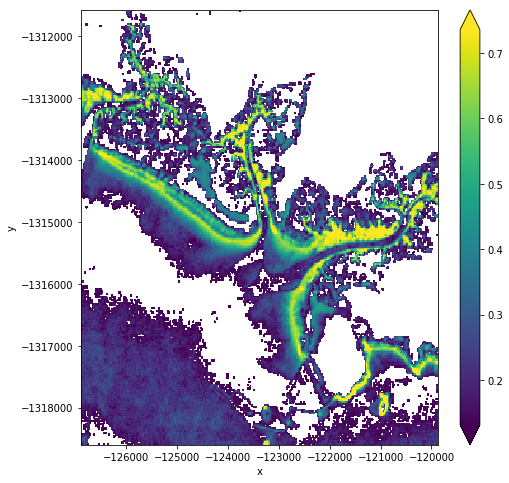

In [40]:
plt.figure(figsize=(8, 8))
cor.where(pval < 0.05).plot(robust=True)

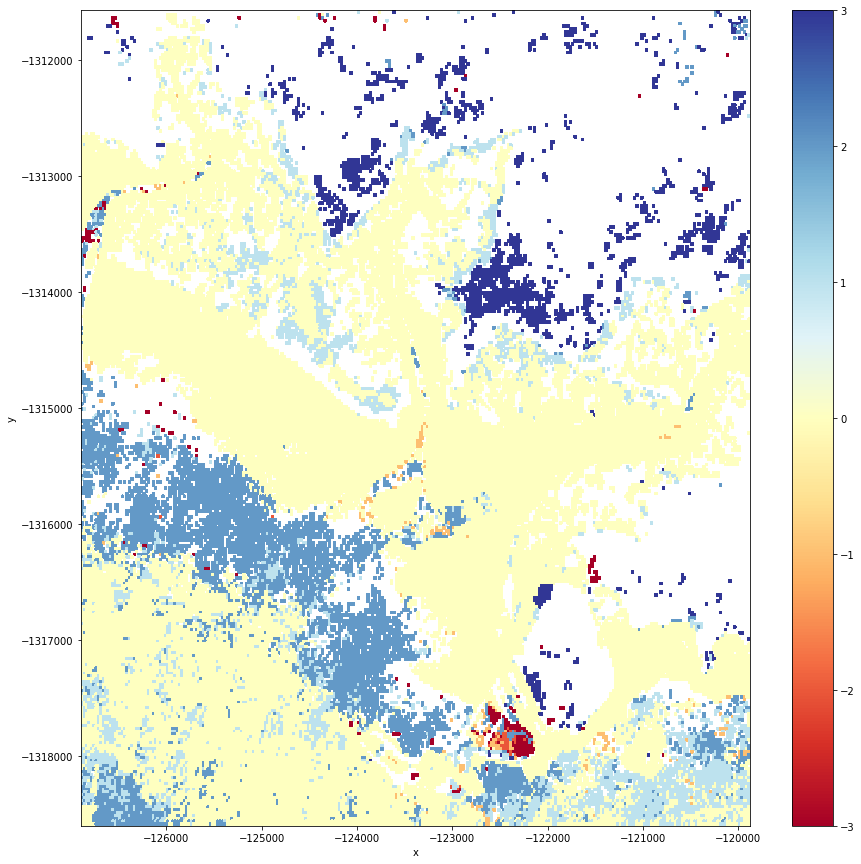

In [47]:
lagged_arrays = []
max_lag = 3
for i in range(-max_lag, max_lag+1):
    
    _, lagged_cor, _, _, lagged_pval, _ = lag_linregress_3D_upright(x=data.tide_heights, y=data.mndwi, lagx=i)
    lagged_arrays.append(lagged_cor.where(lagged_pval < 0.05))
    
lagged_dataarray = xr.concat(lagged_arrays, dim='lag')
lagged_dataarray['lag'] = lagged_dataarray['lag'] - max_lag

plt.figure(figsize=(15, 15))
all_nan = lagged_dataarray.notnull().max(dim=['lag'])
max_index = lagged_dataarray.fillna(0).argmax(dim='lag')
lagged_dataarray['lag'][max_index].where(all_nan).plot(cmap='RdYlBu') 